In [1]:
%matplotlib widget
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import solve_bvp, solve_ivp
from ode_system import stop_at_small_r_step
from EOS import NeutronStarEOS
from omars_little_helpers import *
from scipy.interpolate import interp1d


In [2]:
Msun = 1.988e33
G = 6.6743e-8
c = 3e10

In [3]:
apr_eos = NeutronStarEOS('APR')

In [4]:
# load beta from TOV expansion from Mathematica

data = np.genfromtxt('GR_beta_values.csv', delimiter=',')
rho_c_for_interp = data[:, 0]  # Assuming the first column is rho_c
beta_values_for_interp = data[:, 1]  # Assuming the second column is beta

# Create the interpolation function
beta_of_rho = interp1d(rho_c_for_interp, beta_values_for_interp, kind='cubic')


In [26]:
ri = 1e-15
rf = 1.4e6


    
def GR_initial_conditions(beta_fn, rho_c, ri):
    bbbeta = beta_fn(rho_c)
    rho_initial = rho_c - bbbeta * ri**2
    m_initial = 4.18879 * rho_c * ri**3
    return [rho_initial, m_initial]

def GR_ode_system(r ,y ,P ,dPdRho):
    rho, mass = y
    #if rho < 1:
    #    return np.array([0,0])

    expr_TOV = - (G / c**2) / r**2 * (rho * c**2 + P(rho)) * (mass + (4 * np.pi * r**3 * P(rho) / c**2)) / (1 - 2 * G * mass/(r * c**2))
    expr_TOV /= dPdRho(rho)

    drhodr = expr_TOV

    dmdr = 4 * np.pi * r**2 * rho

    return np.array([drhodr, dmdr])

def ivp_system_wrapper(r, y):
    P = apr_eos.get_pressure(extrapolate=True)
    dPdRho = apr_eos.dP_dRho()
    return GR_ode_system(r ,y ,P ,dPdRho)

In [30]:
GR_initial_conditions(beta_of_rho, 1.8e16, ri)

[1.8e+16, 7.539822000000002e-29]

In [32]:
rho_c = 1.778e16
initial_conditions = GR_initial_conditions(beta_of_rho, rho_c, ri)
sol_ivp = solve_ivp(ivp_system_wrapper, [ri, rf], initial_conditions, method='LSODA', rtol=1e-8, atol=1e-10, events=stop_at_small_r_step)
r_values = sol_ivp.t
rho_values, mass_values = sol_ivp.y
idx_outside = np.argmin(rho_values)
radius_ns = r_values[idx_outside]
mass_ns = mass_values[idx_outside]
print(f"The star has mass = {mass_ns/Msun:0.3} Msun and radius = {radius_ns/1e5:0.3} km")

The star has mass = 3.75e-62 Msun and radius = 1e-20 km


In [23]:
r_values[-10:]

array([799130.40695949, 799130.40695954, 799130.40695958, 799130.40695962,
       799130.40695964, 799130.40695966, 799130.40695968, 799130.40695969,
       799130.40695971, 799130.40695971])

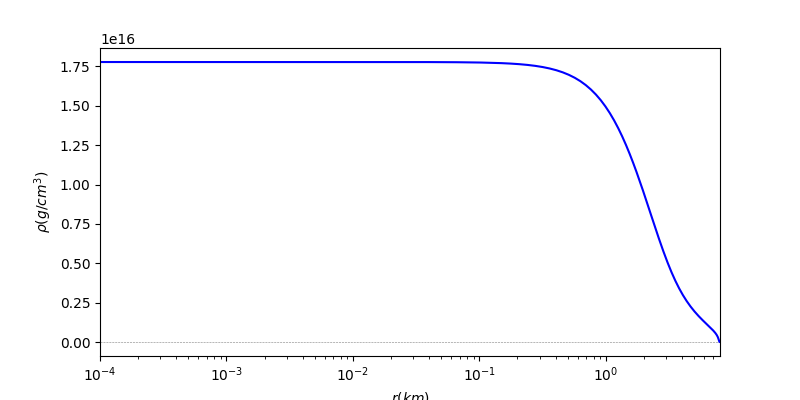

In [24]:
plt.close('all')

#points = np.linspace(ri, radius_ns, 5000)
#solution_at_points = sol_ivp.sol(points)

plot_something(r_values, rho_values, radius=radius_ns, y_label=r"$\rho (g/cm^{3})$")


In [52]:
solution_at_points[0]

array([1.00000000e+15, 1.00030215e+15, 1.00041821e+15, ...,
       7.83519492e+06, 2.23267641e+06, 1.09498667e+00])

# 3) Plotting

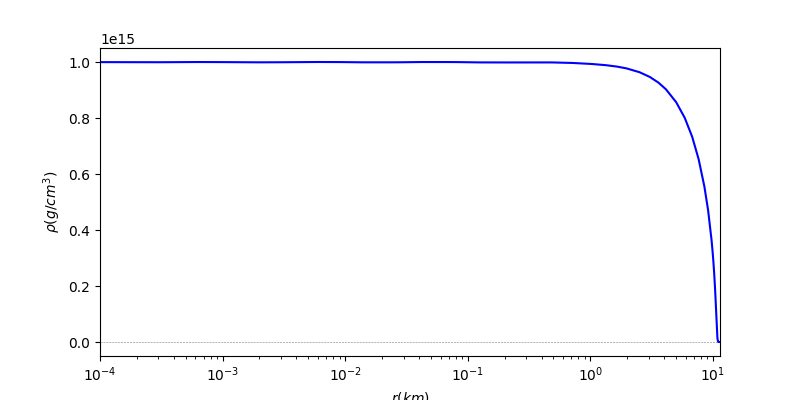

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [44]:
%matplotlib widget
plot_something(r_values, rho_values, radius=radius_ns, y_label=r"$\rho (g/cm^{3})$")
plt.xscale('log')
plt.legend()


In [22]:
plot_somethin(mass/Msun, r, y_label=r"$M/M_{\odot} $")
plt.plot(r_values/1e5, mass_values/Msun, label='IVP')
plt.xscale('log')
plt.legend()

NameError: name 'mass' is not defined